In [160]:
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.anuga import SWW_plotter
import numpy as np
import pandas as pd
%matplotlib inline
import geopandas as gpd
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from netCDF4 import Dataset
from glob import glob
from osgeo import gdal

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [161]:
crossSection= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/outlet_cross_section/outlet_cross_section.shp')

In [162]:
dr= pd.date_range('20170825000000','20170826000000', freq='120S')

In [163]:
OUTLET= (287051.8746,3292014.0105)

In [176]:
coupled= processSWW('Coupled_10m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [177]:
noncoupled= processSWW('nonCoupled_10m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [178]:
coupled_30m = processSWW('Coupled_30m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [179]:
coupled_100m = processSWW('Coupled_100m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [180]:
coupled['area']= coupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
noncoupled['area']= noncoupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
coupled_30m['area']= coupled_30m.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
coupled_100m['area']= coupled_100m.apply(lambda x: flow_area(crossSection, x.stage), axis=1)

In [181]:
coupled['Q']= coupled.speed * coupled.area
noncoupled['Q']= noncoupled.speed * noncoupled.area
coupled_30m['Q']= coupled_30m.speed * coupled_30m.area
coupled_100m['Q']= coupled_100m.speed * coupled_100m.area

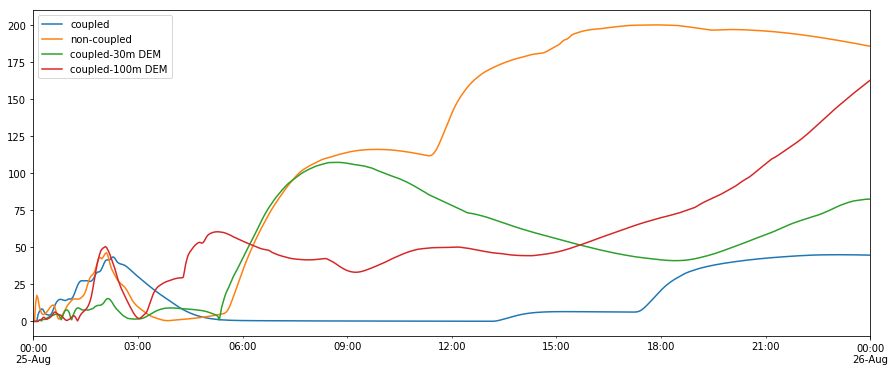

In [185]:
plt.figure(figsize=(15,6))
coupled.Q.plot(label='coupled')
noncoupled.Q.plot(label='non-coupled')
coupled_30m.Q.plot(label='coupled-30m DEM')
coupled_100m.Q.plot(label='coupled-100m DEM')
plt.legend();

In [22]:
first=True
for fname in glob('/home/ZhiLi/CRESTHH/data/synthetic_rainfall/*.tif'):
    if first:
        arr= gdal.Open(fname).ReadAsArray()/1000./3600.
        first=False
    else:
        arr+= gdal.Open(fname).ReadAsArray()/1000./3600.

In [12]:
xc= splotter.xc+ splotter.xllcorner
yc= splotter.yc+ splotter.yllcorner
iloc= np.argmin( (xc-OUTLET[0])**2 + (yc-OUTLET[1])**2 )

In [42]:
splotter= SWW_plotter('Coupled_10m_modified_mesh.sww', start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [12]:
xc= splotter.xc+ splotter.xllcorner
yc= splotter.yc+ splotter.yllcorner
iloc= np.argmin( (xc-OUTLET[0])**2 + (yc-OUTLET[1])**2 )

In [13]:
river= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/longest_reach/longest_reach.shp')

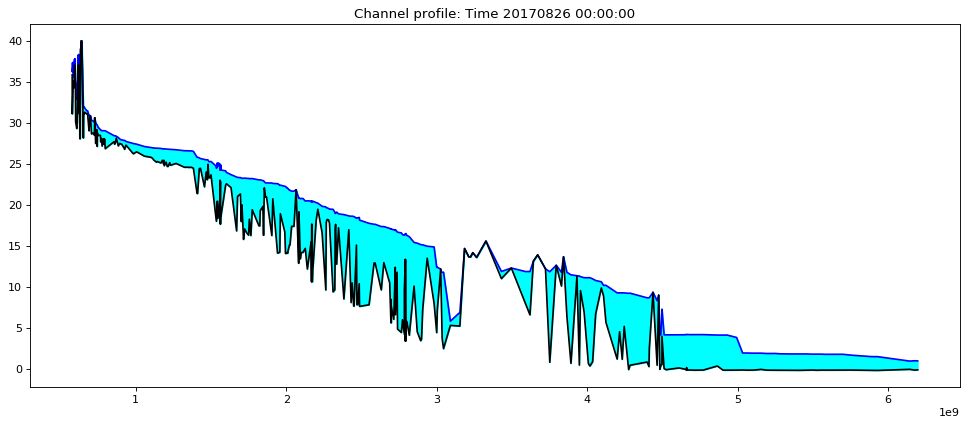

In [32]:
splotter.plot_longitudinal_frame(np.array(river.geometry[0]),frame=-1)

In [137]:
for i, time in enumerate(splotter.time):
#     print time
    if i>100:
        pass
    else:
#         splotter.save_depth_frame(frame=i, cmap='Blues', vmin=0, vmax=10, dpi=80)
        splotter.save_longitudinal_frame(np.array(river.geometry[0]), frame=i,  dpi=80)

<Figure size 1080x576 with 0 Axes>

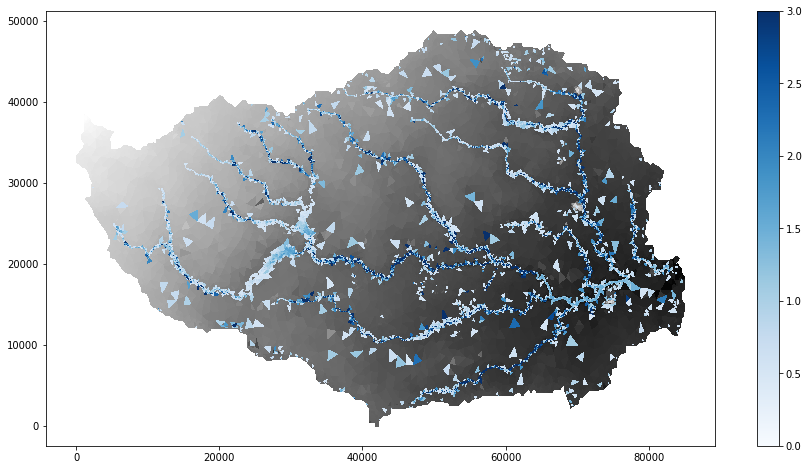

In [45]:
plt.figure(figsize=(15,8))
splotter.triang.set_mask(splotter.depth.mean(axis=0) > .5)
plt.tripcolor(splotter.triang,
              facecolors=splotter.elev,
              cmap='gray')
splotter.triang.set_mask(splotter.depth.mean(axis=0) < .5)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.depth).mean(axis=0),
              cmap='Blues',
             vmin=0,
             vmax=3)
plt.colorbar()

<Figure size 1080x576 with 0 Axes>

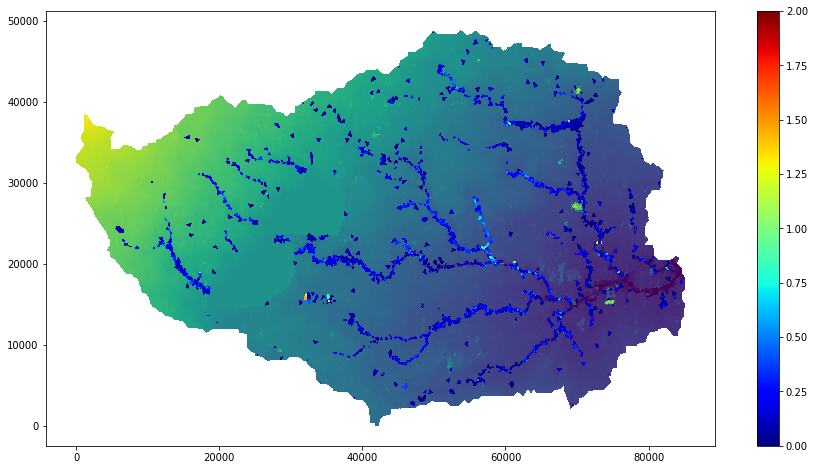

In [8]:
plt.figure(figsize=(15,8))
splotter.triang.set_mask(splotter.depth.max(axis=0) > 1)
plt.tripcolor(splotter.triang,
              facecolors=splotter.elev,
              cmap='viridis')
splotter.triang.set_mask(splotter.depth.max(axis=0) <=1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()

In [121]:
nc= Dataset('Coupled_10m_modified_mesh.sww')

In [110]:
new_nc= Dataset('ext_sensitivity.sww', 'w')

In [111]:
def createVariables(new_nc, nc, group='10m_coupled'):
    new_nc.createGroup(group)
    new_nc[group].createDimension('num_time', nc.dimensions['number_of_timesteps'].size)
    new_nc[group].createDimension('num_volumes', nc.dimensions['number_of_volumes'].size)
    new_nc[group].createDimension('num_vertices', nc.dimensions['number_of_vertices'].size)
    new_nc[group].createDimension('num_points', nc.dimensions['number_of_points'].size)
    new_nc[group].createVariable('time', nc['time'].dtype, ('num_time'))
    new_nc[group].createVariable('x', nc['x'].dtype, ('num_points'))
    new_nc[group].createVariable('y', nc['y'].dtype, ('num_points'))
    new_nc[group].createVariable('volumes', nc['volumes'].dtype, ('num_volumes', 'num_vertices'))
    new_nc[group].createVariable('depth', nc['stage_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('speed', nc['xmomentum_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('SM', nc['xmomentum_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('triangles', nc['xmomentum_c'].dtype, ('num_volumes', 'num_vertices'))
    new_nc[group+'/time'][:]= nc['time'][:]
    new_nc[group+'/x'][:]= nc['x'][:]
    new_nc[group+'/y'][:]= nc['y'][:]
    new_nc[group+'/volumes'][:]= nc['volumes'][:]
    new_nc[group+'/depth'][:]= nc['stage_c'][:] - nc['elevation_c'][:]
    new_nc[group+'/speed'][:]= (nc['xmomentum_c'][:]**2 + nc['ymomentum_c'][:]**2)**.5
    new_nc[group+'/SM'][:] = nc['SM_c'][:]
    new_nc[group].xllcorner= nc.xllcorner
    new_nc[group].yllcorner= nc.yllcorner
    
# new_nc.createGroup('10m_uncoupled')
# new_nc.createGroup('30m_coupled')
# new_nc.createGroup('100m_coupled')

In [122]:
createVariables(new_nc,nc,'10m_coupled')

In [123]:
new_nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 100m_coupled, 10m_noncoupled, 30m_coupled, 10m_coupled

In [124]:
new_nc.close()